In [1]:
import numpy as np; np.random.seed(0)
import tensorflow as tf; tf.set_random_seed(seed=0)
import pandas as pd
import lightgbm as lgb
import gc
from collections import defaultdict
import matplotlib

In [2]:
train = pd.read_pickle('data/train_original.pkl')
test = pd.read_pickle('data/test_original.pkl')
special_cols = [col for col in train.columns if train[col].dtype != np.float64]
feature_cols = [col for col in train.columns if col not in special_cols]
target = train.target.values

In [3]:
if False:
    from tqdm import tqdm
    def transform_freq_feature(df1,df2,df3_base,feat):
        val1=df1[feat].values
        val2=df3_base[feat].values

        defa1=defaultdict(lambda:0)

        for val in val1:
            defa1[str(val)]+=1.
        for val in val2:
            defa1[str(val)]+=1.  

        df1[feat +"_freq"]= df1[feat].apply(lambda x :defa1[str(x)] ) 
        df2[feat+"_freq"]= df2[feat].apply(lambda x :defa1[str(x)] )  

    def load_data():
        train_df = train[feature_cols].copy()
        test_df = test[feature_cols].copy()
        real_test_df = test[feature_cols].copy()

        unique_samples = []
        unique_count = np.zeros_like(test_df)
        for feature in tqdm(range(test_df.shape[1])):
            _, index_, count_ = np.unique(test_df.values[:, feature], return_counts=True, return_index=True)
            unique_count[index_[count_ == 1], feature] += 1

        # Samples which have unique values are real the others are fake
        real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
        synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]
        pd.to_pickle(real_samples_indexes, 'data/test_real_samples_indexes')
    
        real_test_df=real_test_df.iloc[real_samples_indexes]
        print(real_test_df.shape[0])
        print(len(synthetic_samples_indexes))

        columns=train_df.columns.values
        for col in tqdm(columns):
            transform_freq_feature(train_df,test_df,real_test_df,col)
            
        '''
        train_df = pd.concat([train_df,
                              pd.read_pickle('features/cnt_diff_to_expected_norm_dist_train')], axis=1)
        test_df = pd.concat([test_df,
                            pd.read_pickle('features/cnt_diff_to_expected_norm_dist_test')], axis=1)
        '''
        
        print(train_df.isnull().sum().sum(), test_df.isnull().sum().sum(),)
        return train_df, test_df, real_samples_indexes
    
    train_df, test_df, te_real_samples_indexes = load_data()
    
    '''
    for f in tqdm(feature_cols[:200]): # transform into probability
        train_df[f] = 1/(1+np.exp(-train_df[f]))
        test_df[f] = 1/(1+np.exp(-test_df[f]))
        
    from sklearn.preprocessing import MinMaxScaler
    for f in tqdm(feature_cols): # process for non-unique 
        mm = MinMaxScaler(feature_range=(-2, 2))
        mm.fit(train_df[f].append(test_df[f]).values.reshape((-1,1)))
        train_val = mm.transform(train_df[[f]].values).reshape((-1,))
        test_val = mm.transform(test_df[[f]].values).reshape((-1,))
        
        new_f = f+'_exp'
        train_df[new_f] = np.where(train_df[f+'_freq']>1, 2, 1)**train_val
        test_df[new_f] = np.where(test_df[f+'_freq']>1, 2, 1)**test_val
    '''    
        
    for f in tqdm(feature_cols): # normalzie
        vals = train_df[f].append(test_df.loc[te_real_samples_indexes,f]).values
        m, s = vals.mean(), vals.std()
        train_df[f] = (train_df[f]-m)/s
        test_df[f] = (test_df[f]-m)/s
        
    print(train_df.isnull().sum().sum(), test_df.isnull().sum().sum(),)
    train_df.to_pickle('data/nn_data_preprocessed_train.pkl')
    test_df.to_pickle('data/nn_data_preprocessed_test.pkl')
else:
    train_df = pd.read_pickle('data/nn_data_preprocessed_train.pkl')
    test_df = pd.read_pickle('data/nn_data_preprocessed_test.pkl')
    real_samples_indexes = pd.read_pickle('data/test_real_samples_indexes')

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.94it/s]


100000
100000


100%|████████████████████████████████████████████████████████████████████████████| 200/200 [02:17<00:00,  1.04s/it]


0 0


100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.59it/s]


0 0


In [4]:
train_df.shape

(200000, 600)

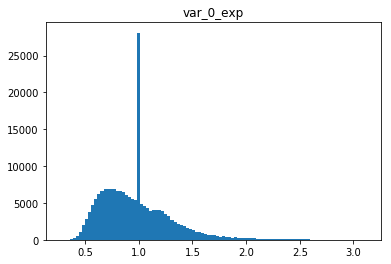

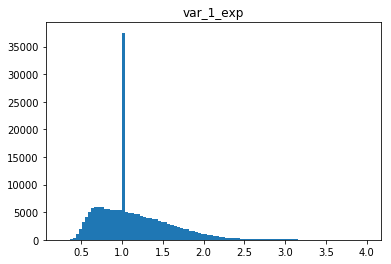

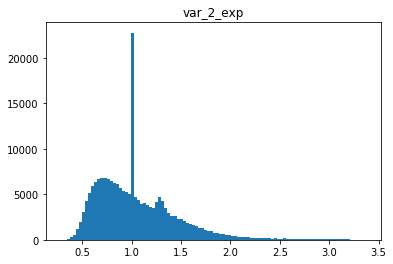

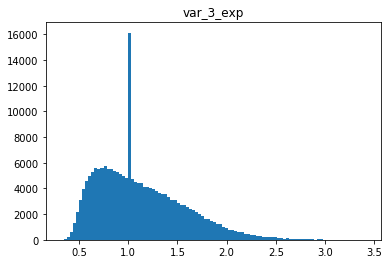

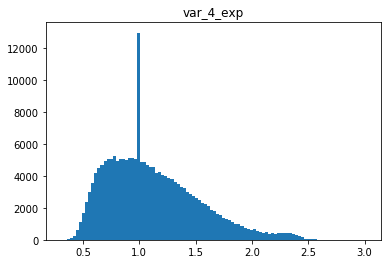

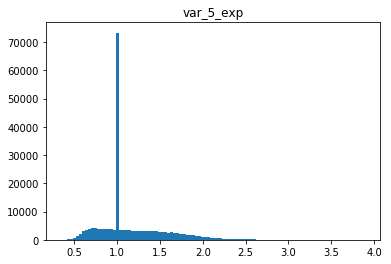

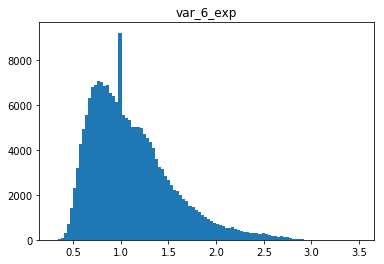

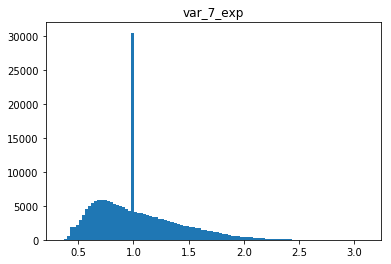

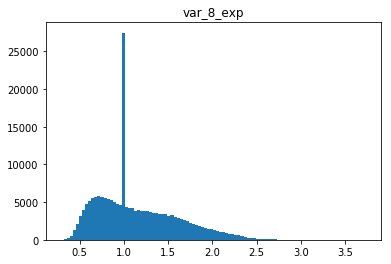

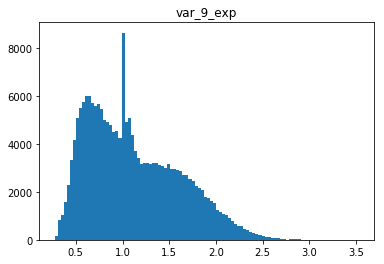

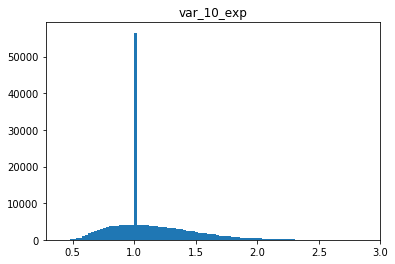

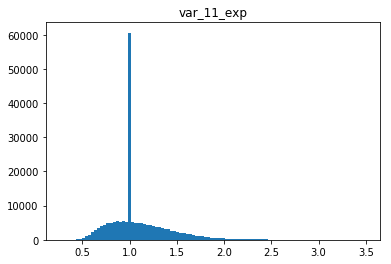

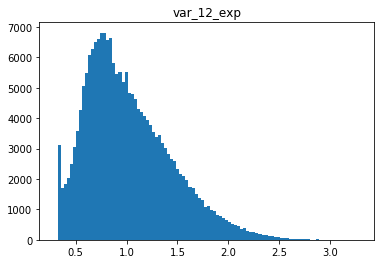

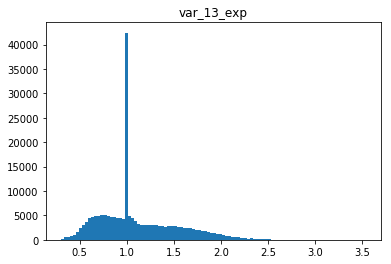

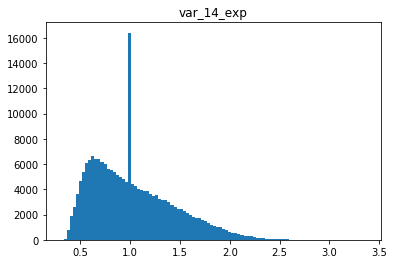

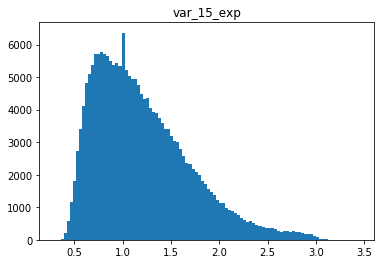

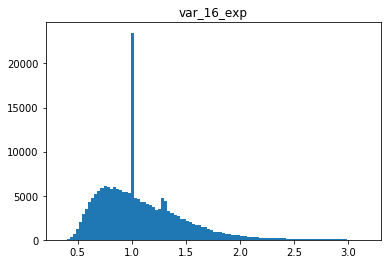

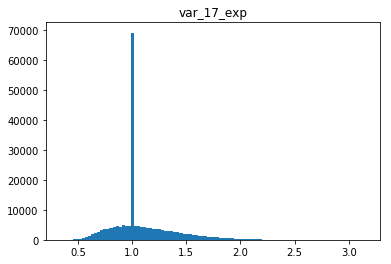

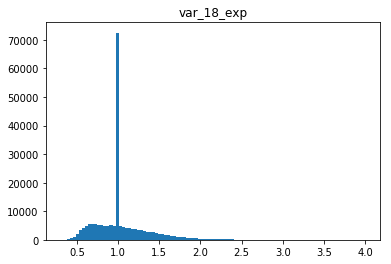

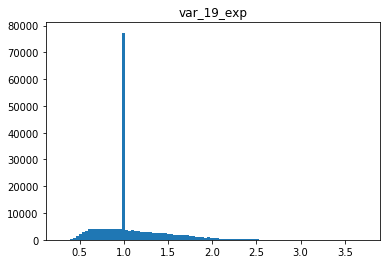

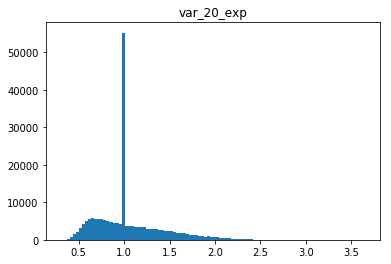

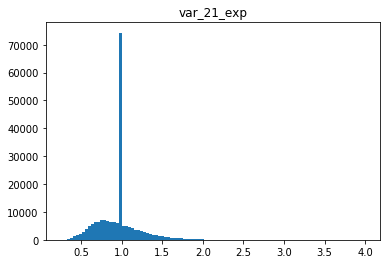

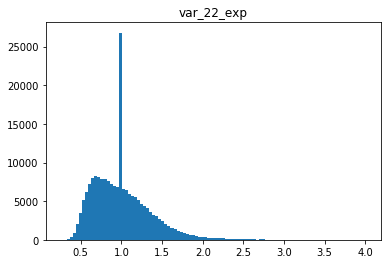

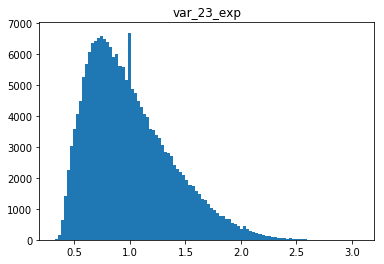

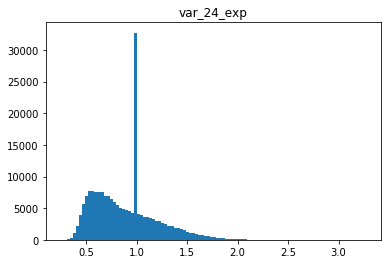

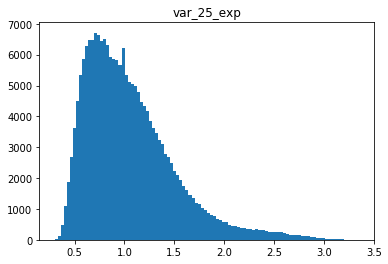

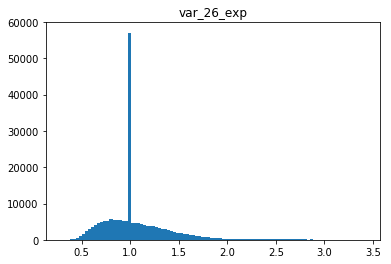

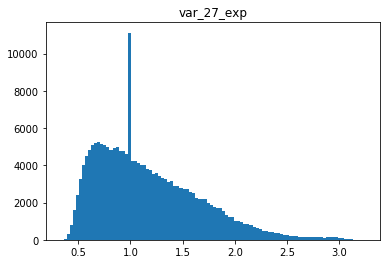

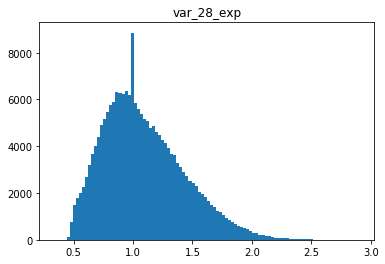

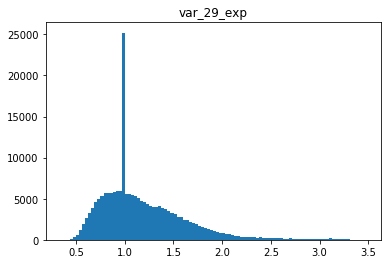

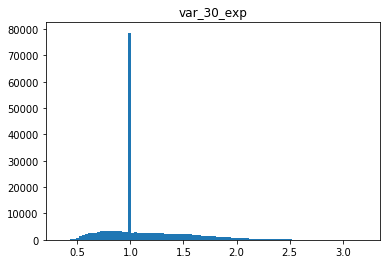

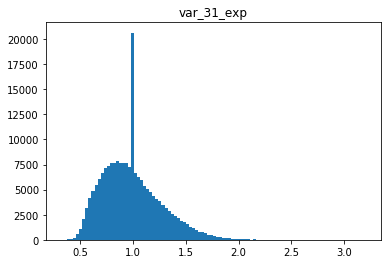

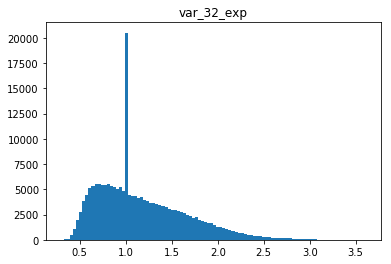

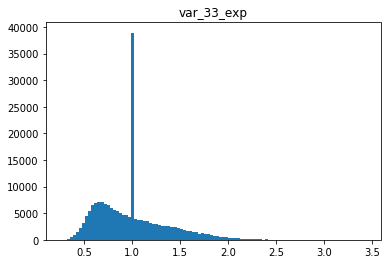

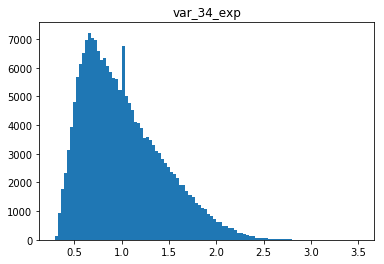

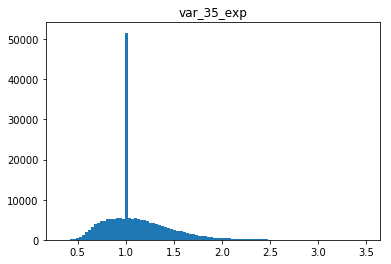

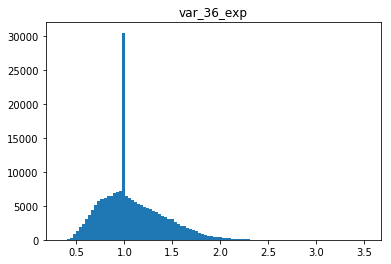

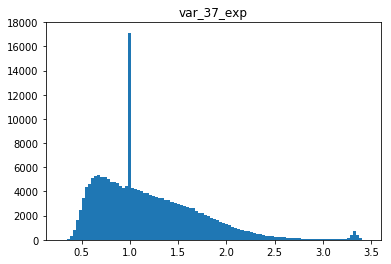

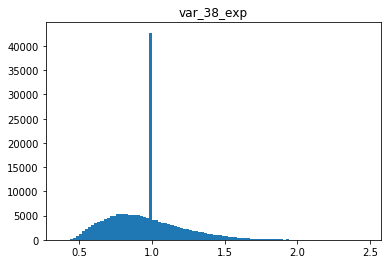

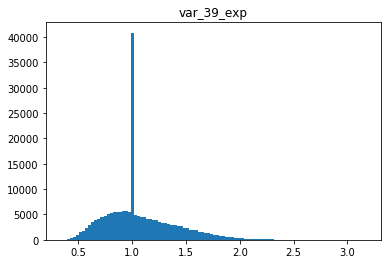

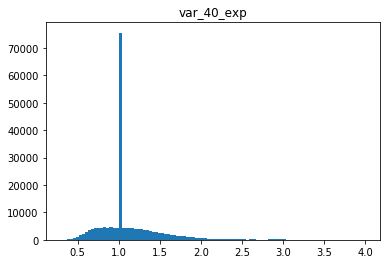

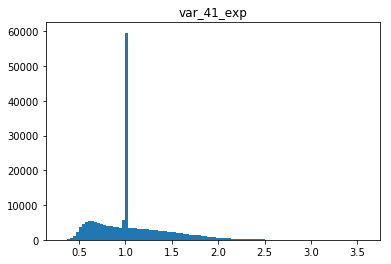

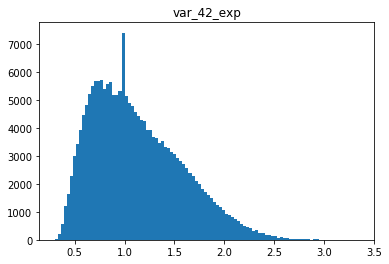

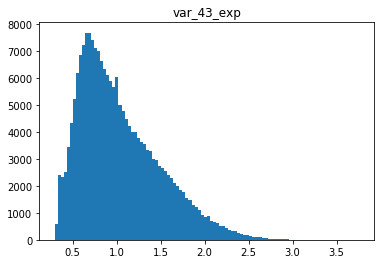

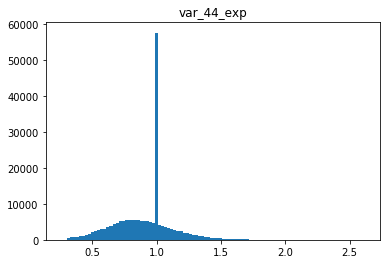

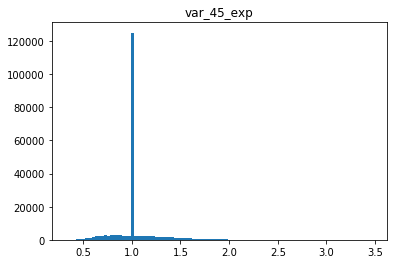

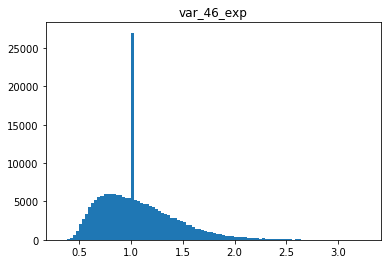

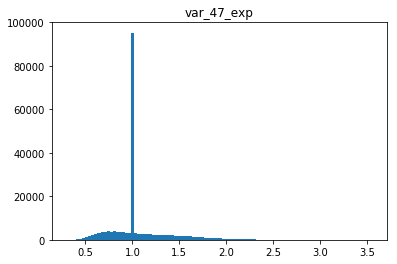

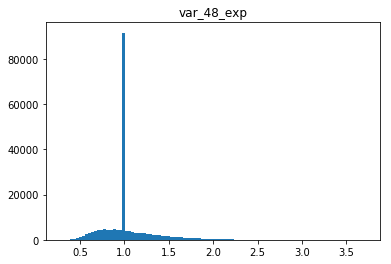

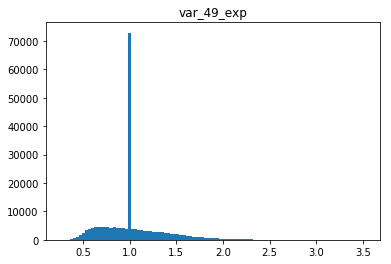

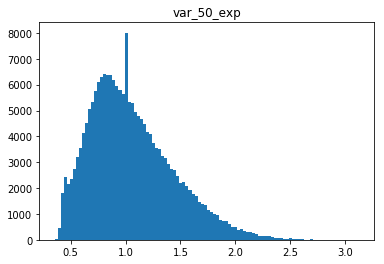

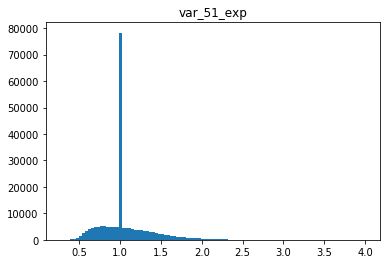

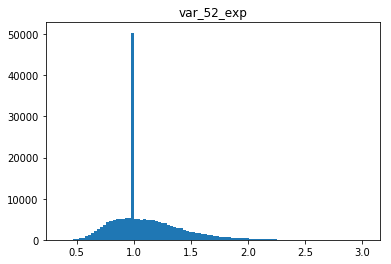

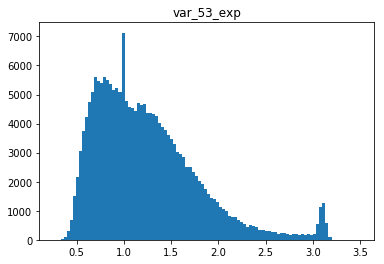

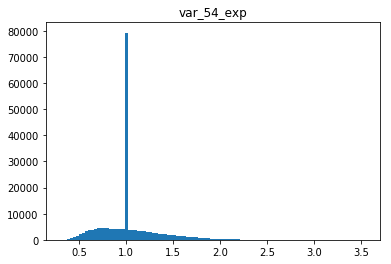

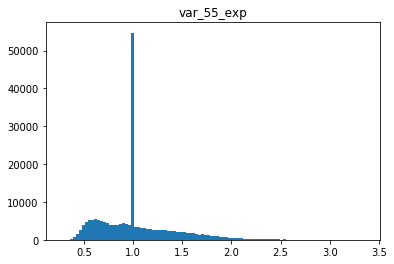

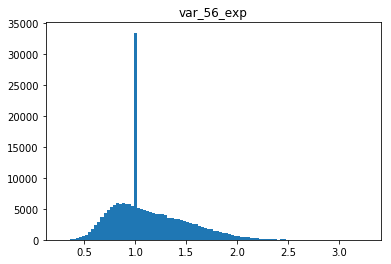

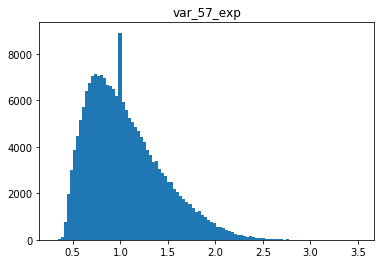

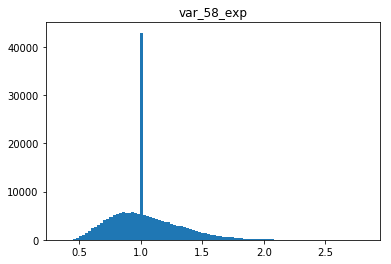

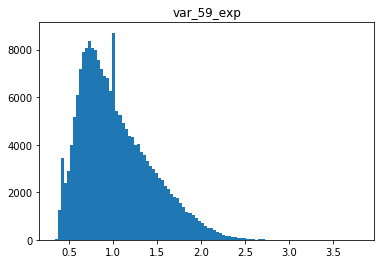

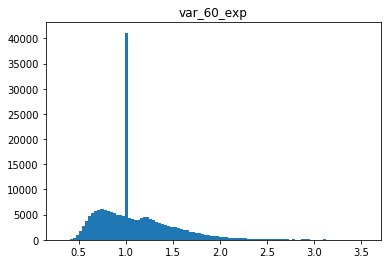

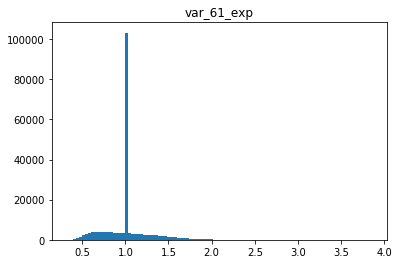

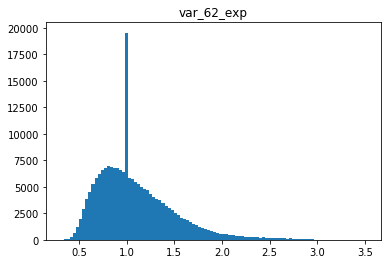

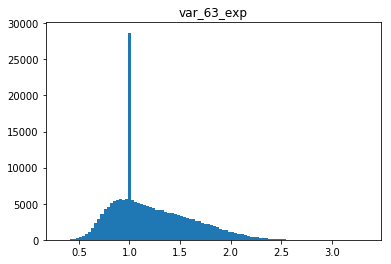

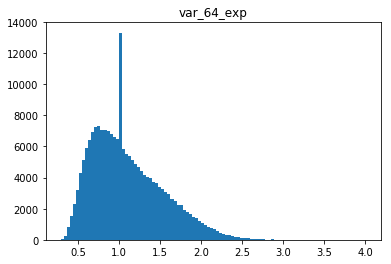

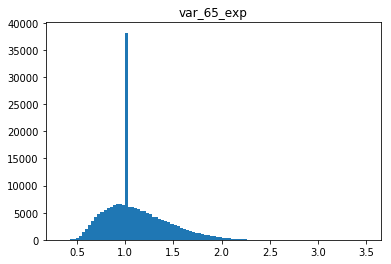

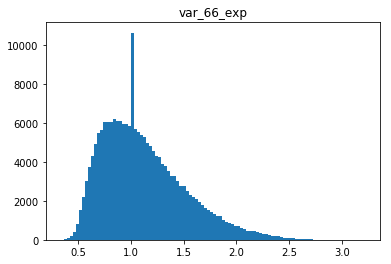

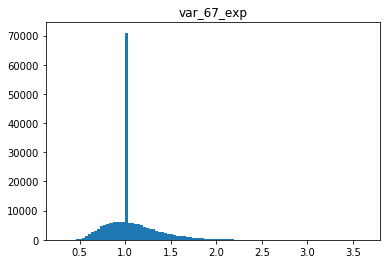

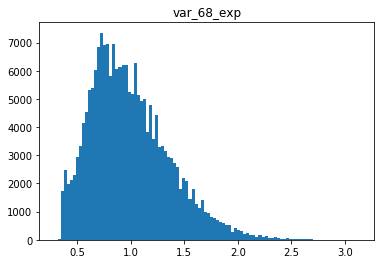

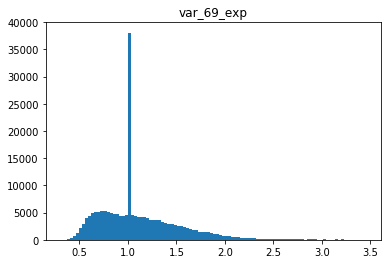

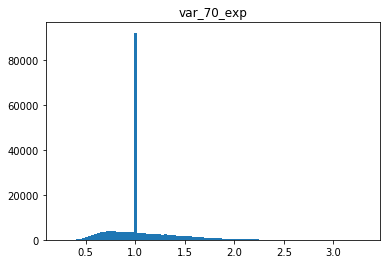

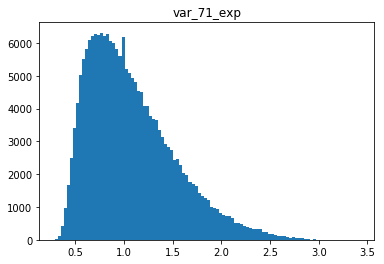

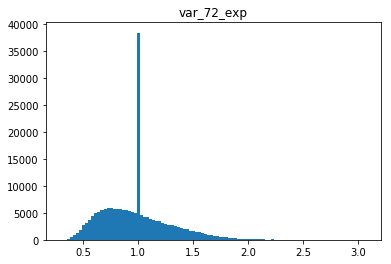

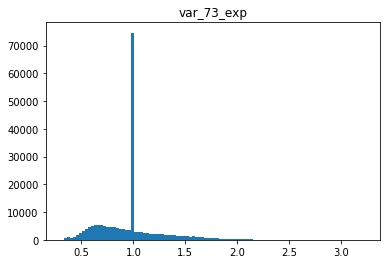

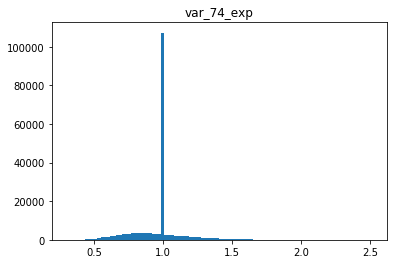

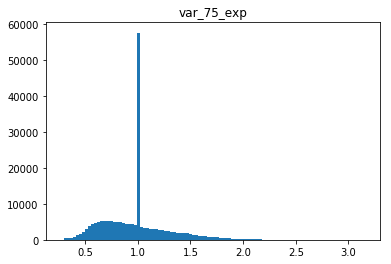

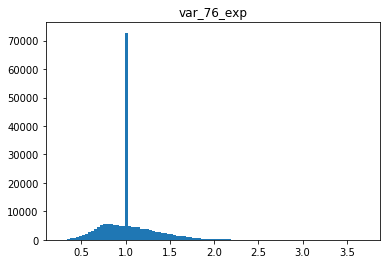

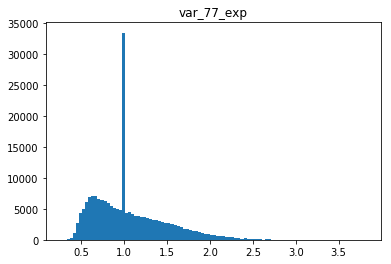

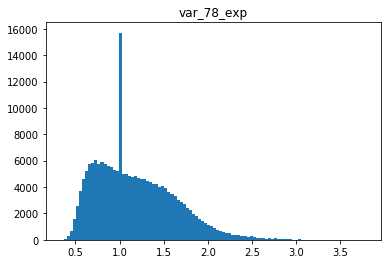

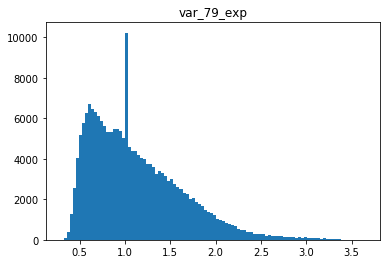

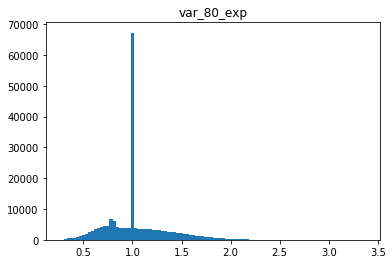

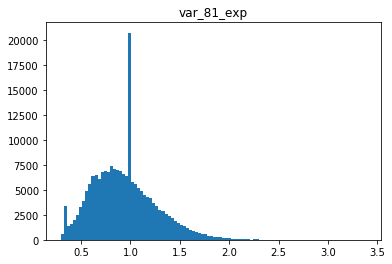

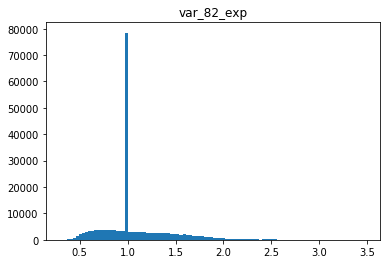

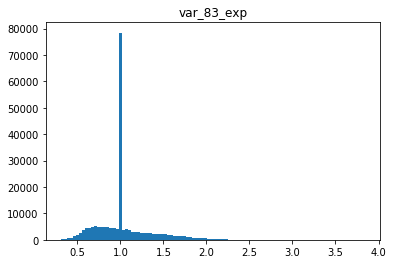

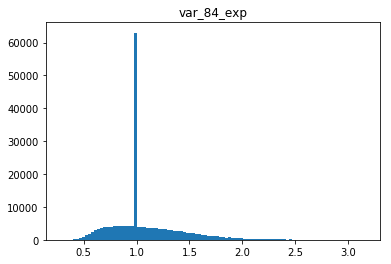

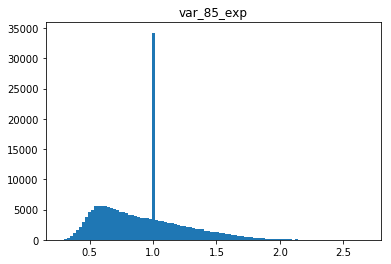

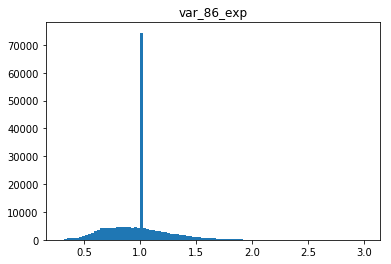

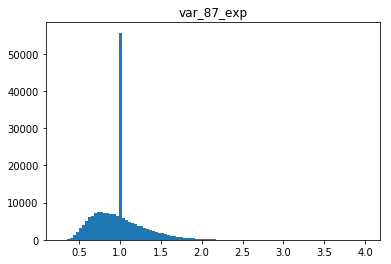

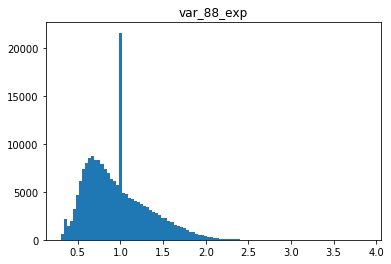

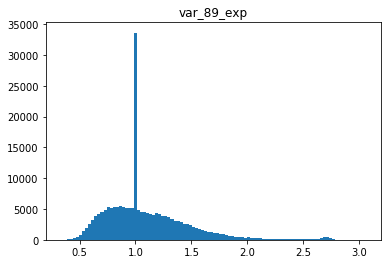

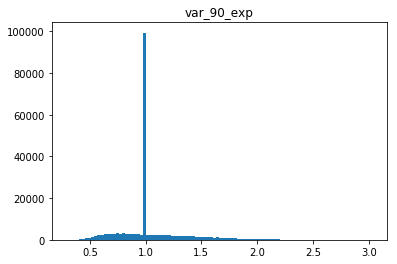

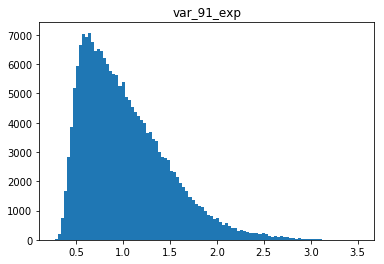

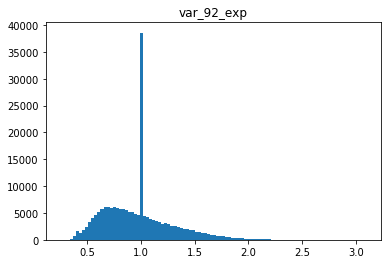

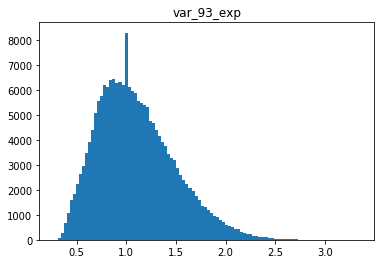

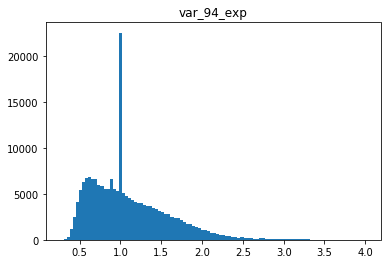

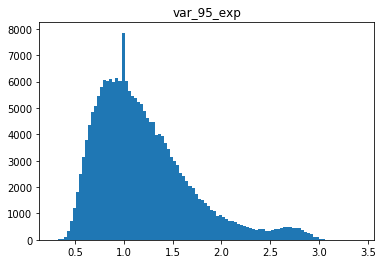

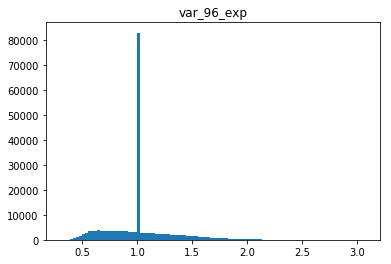

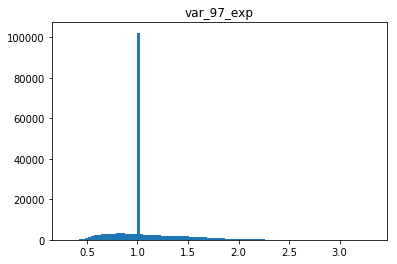

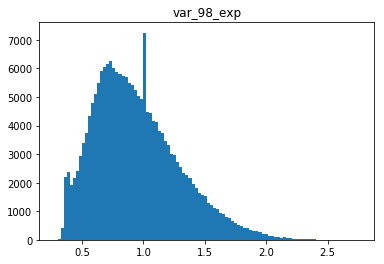

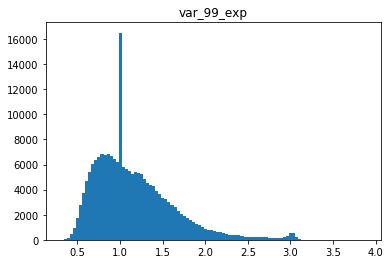

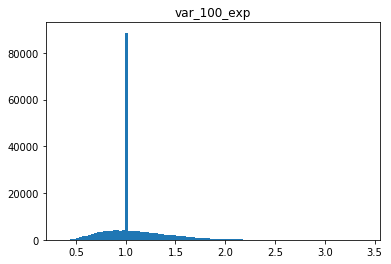

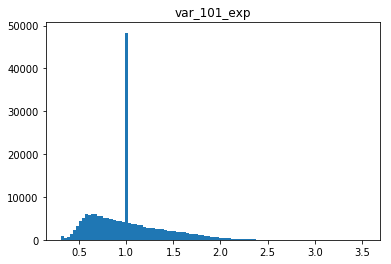

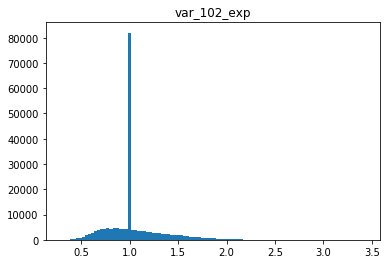

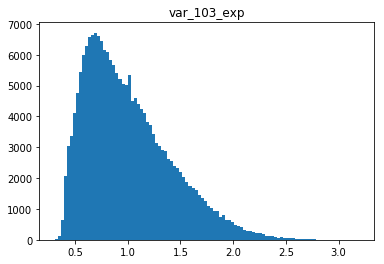

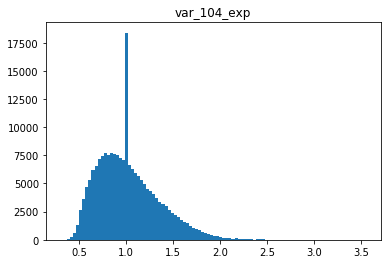

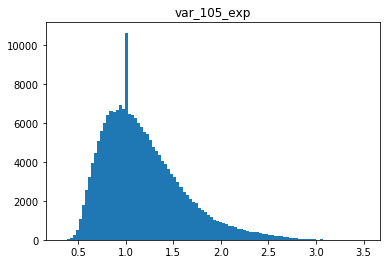

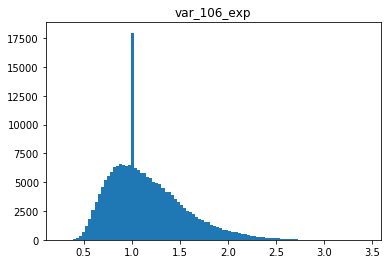

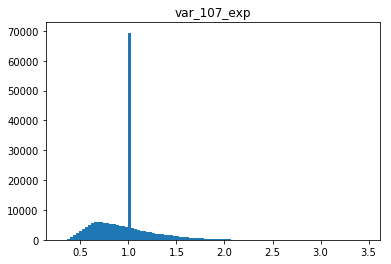

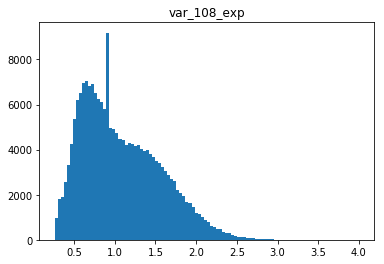

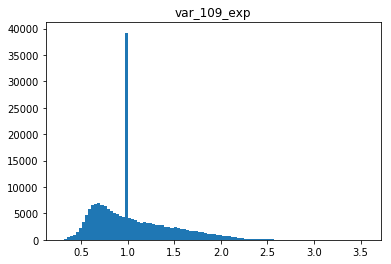

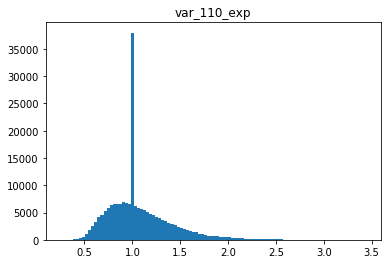

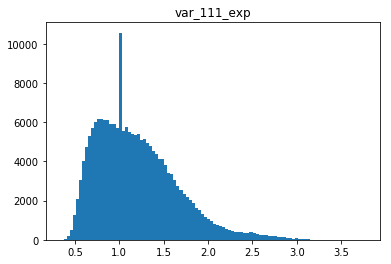

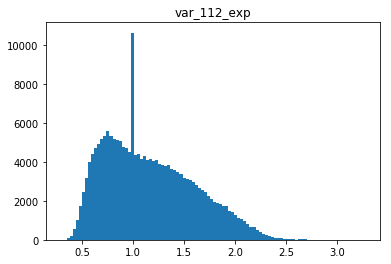

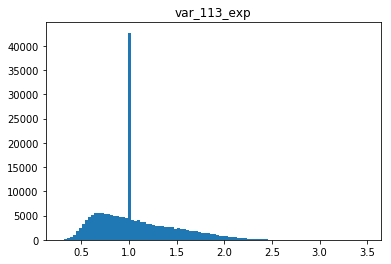

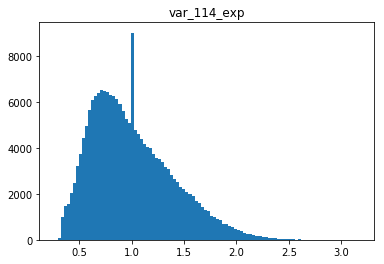

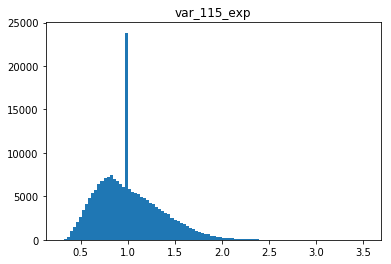

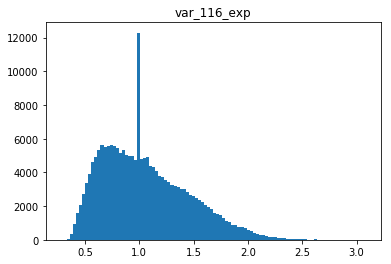

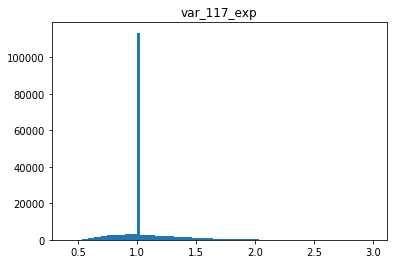

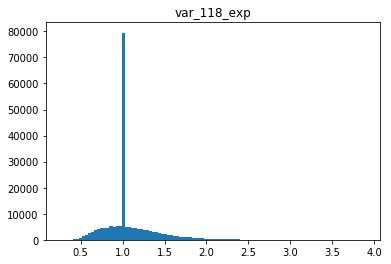

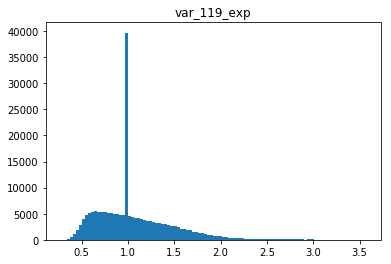

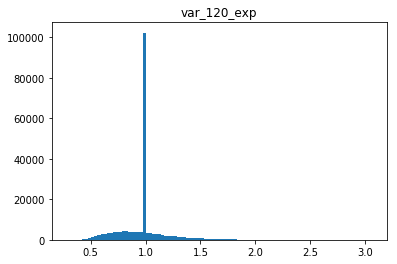

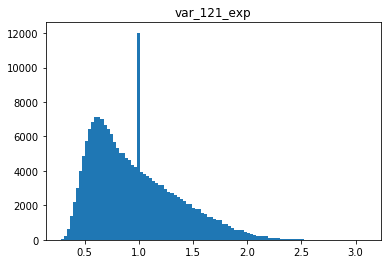

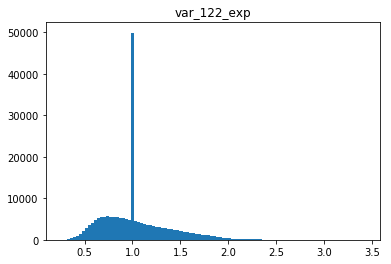

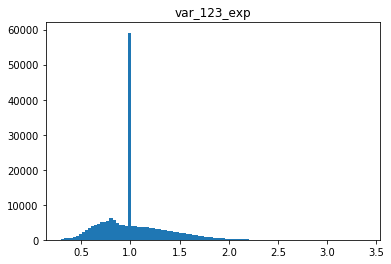

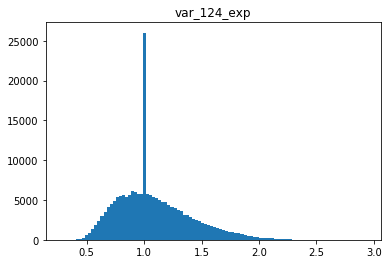

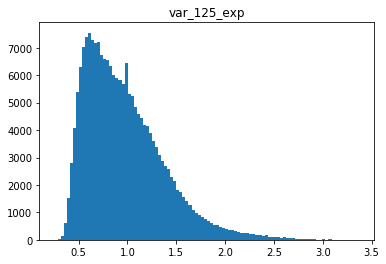

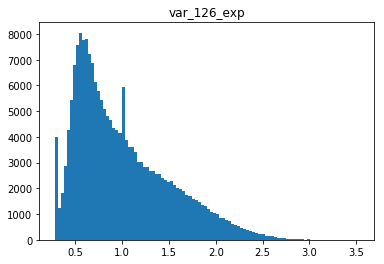

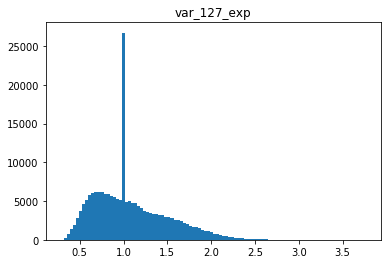

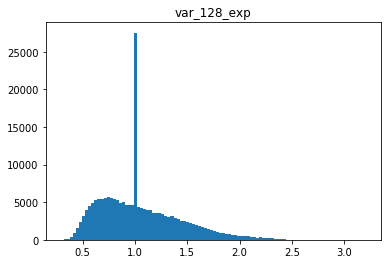

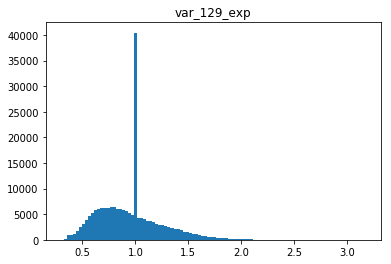

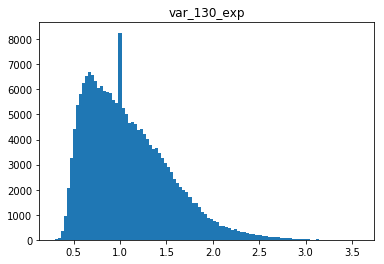

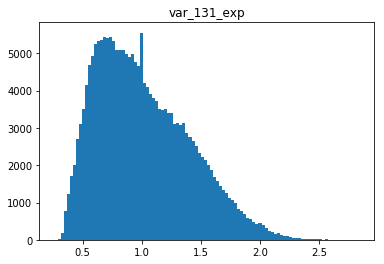

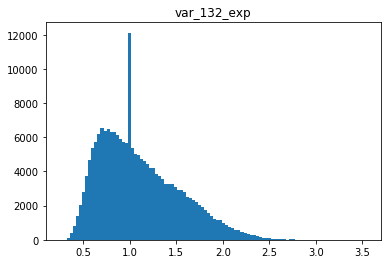

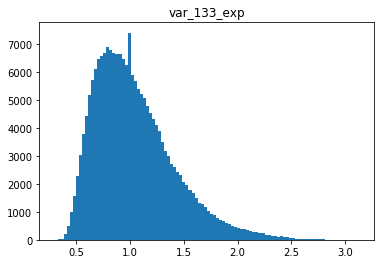

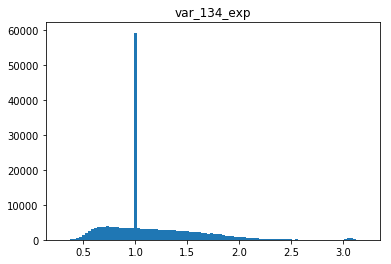

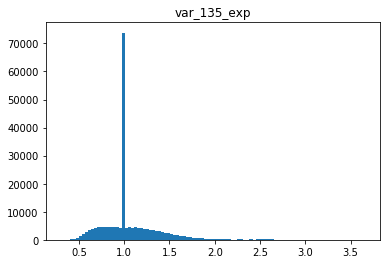

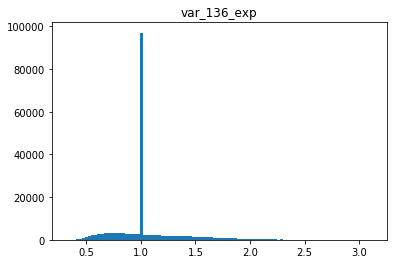

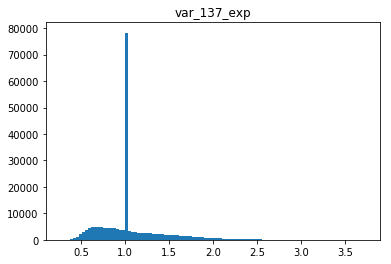

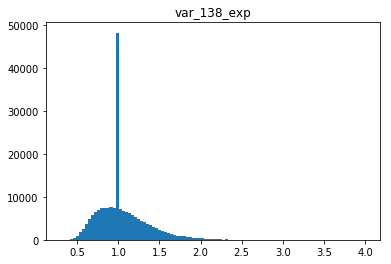

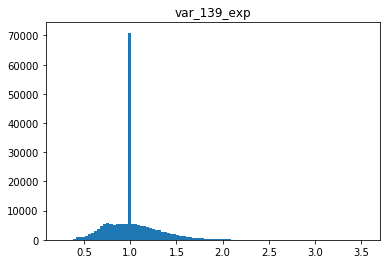

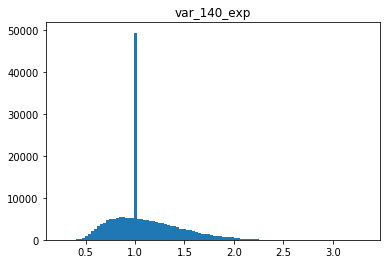

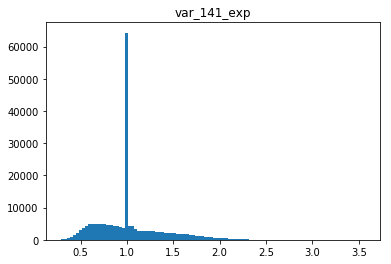

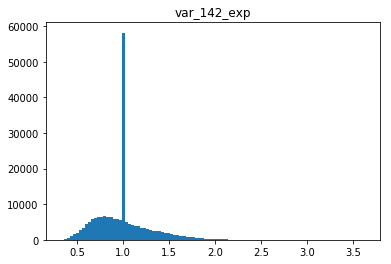

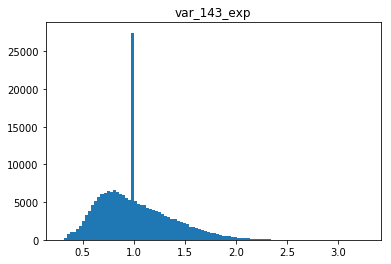

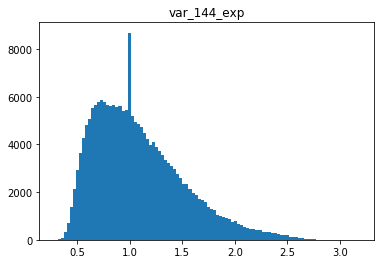

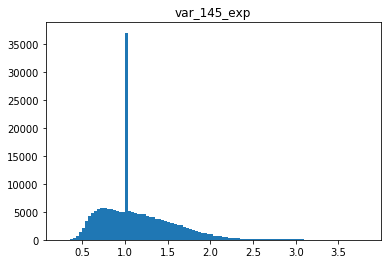

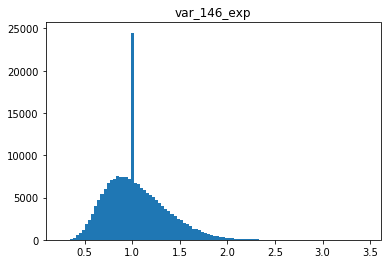

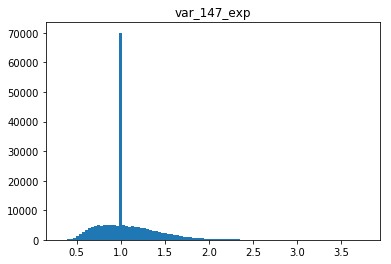

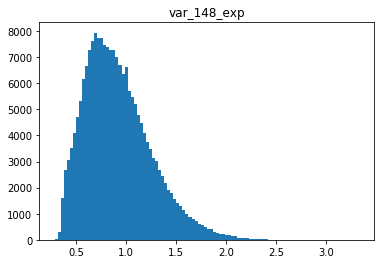

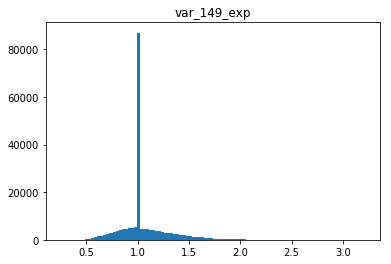

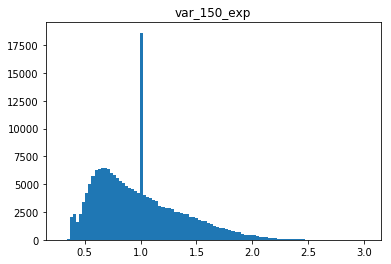

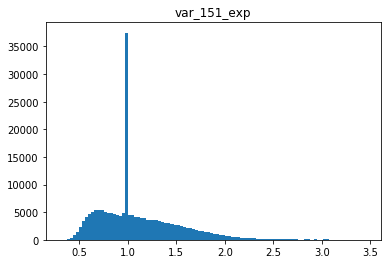

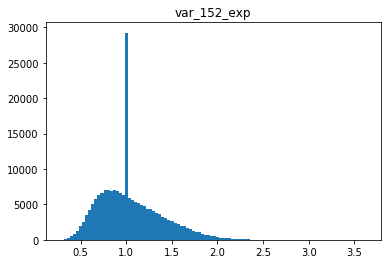

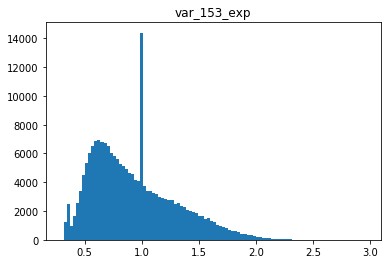

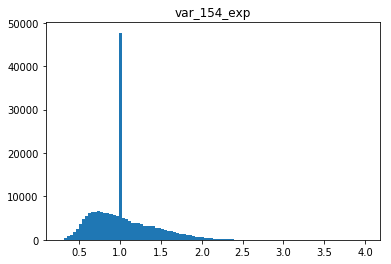

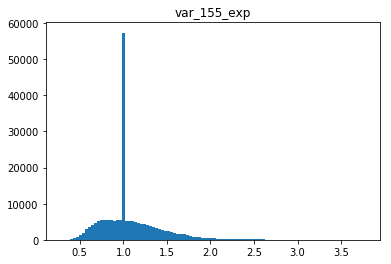

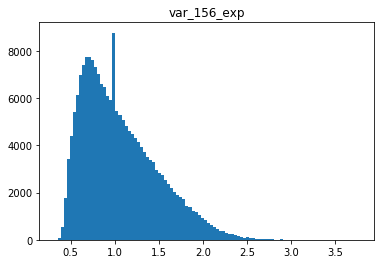

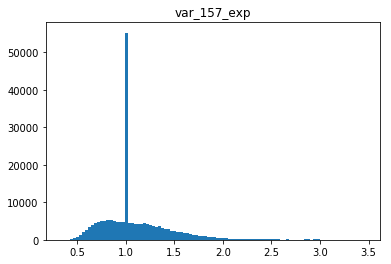

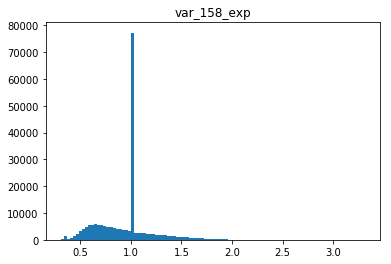

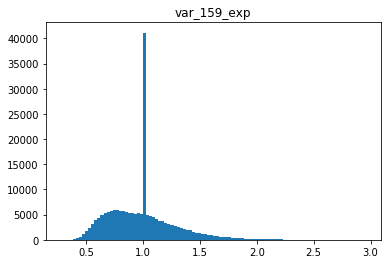

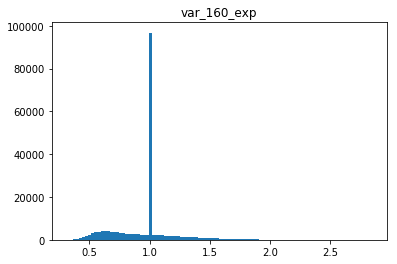

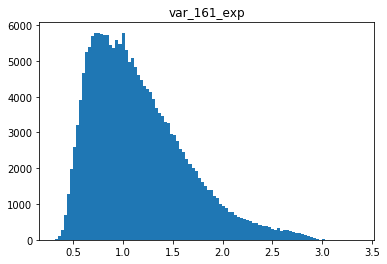

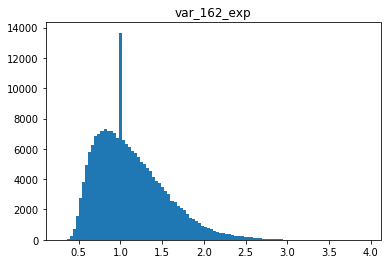

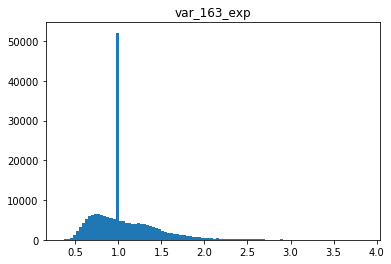

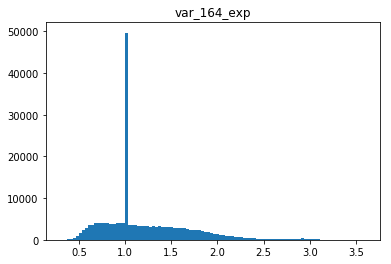

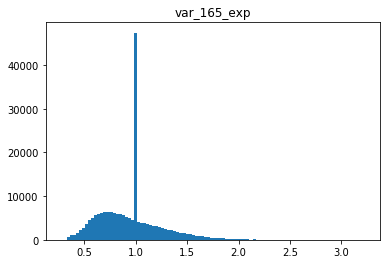

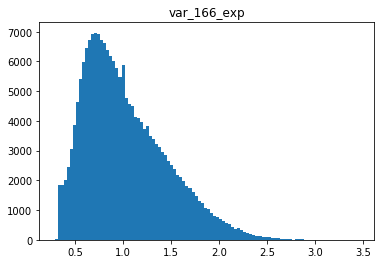

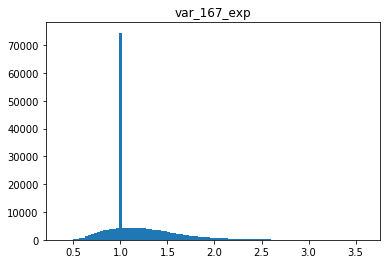

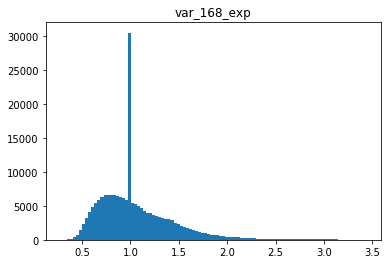

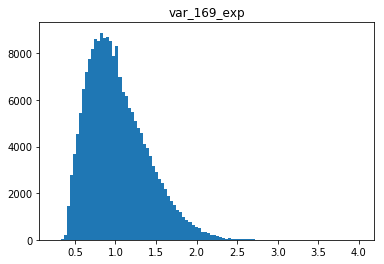

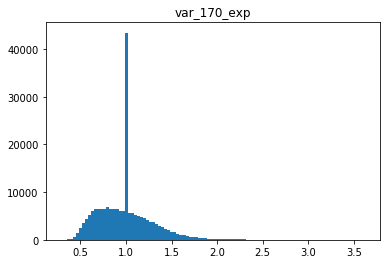

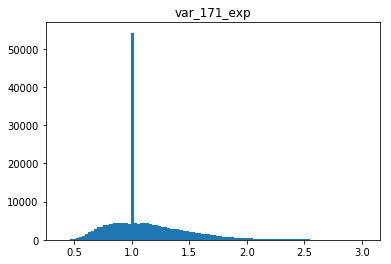

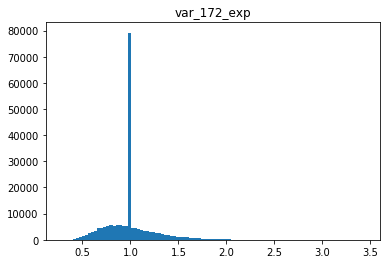

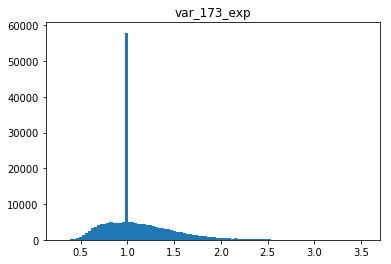

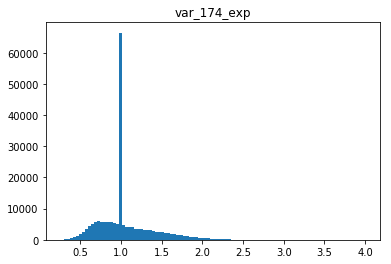

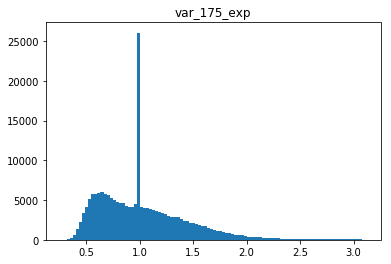

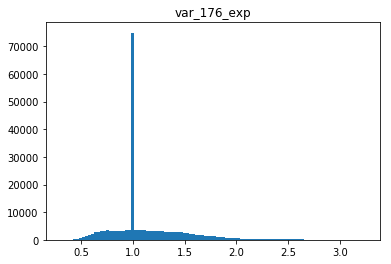

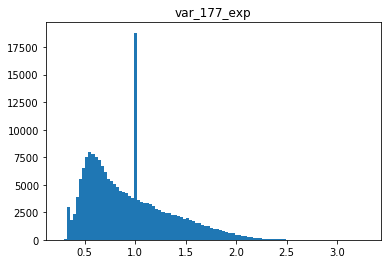

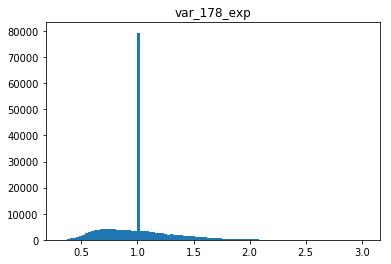

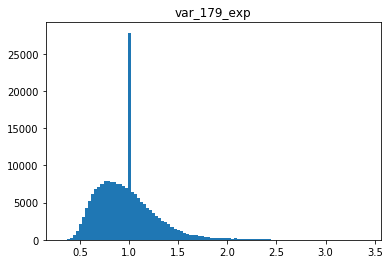

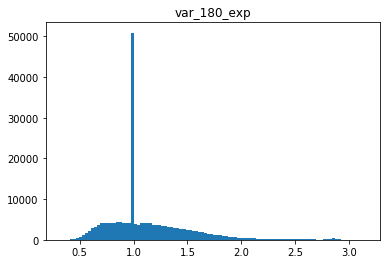

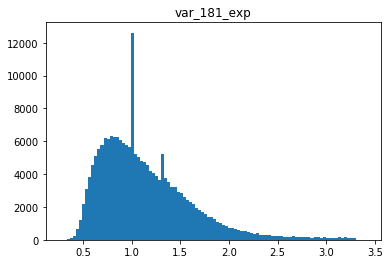

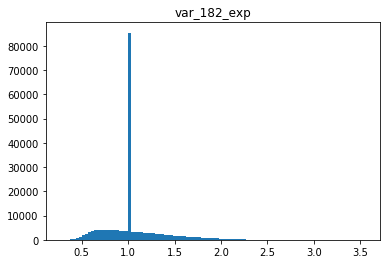

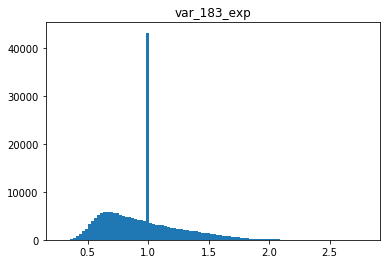

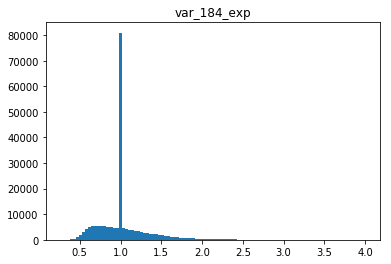

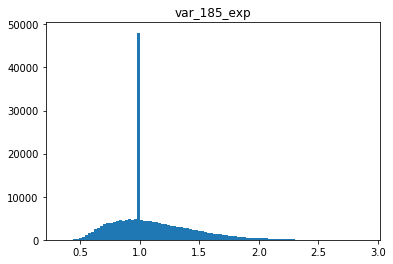

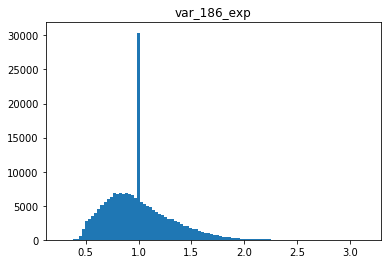

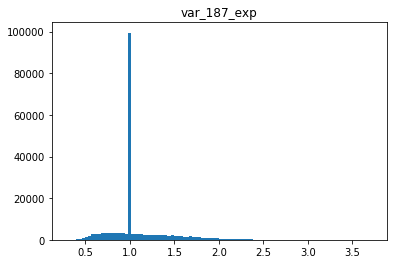

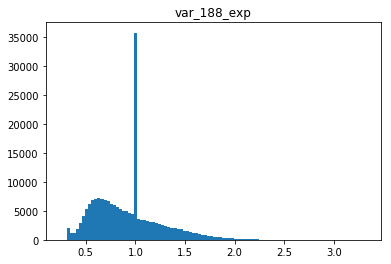

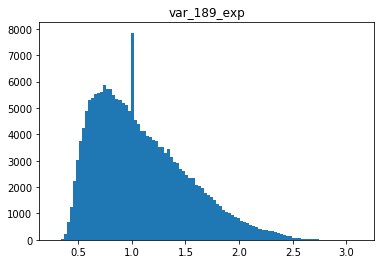

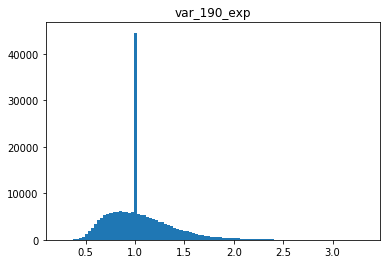

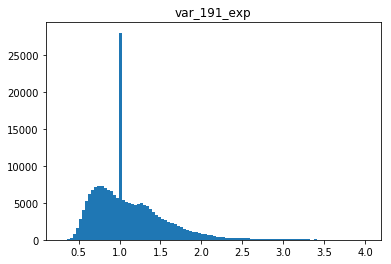

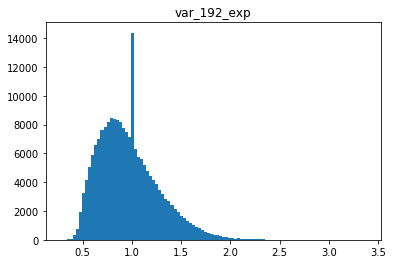

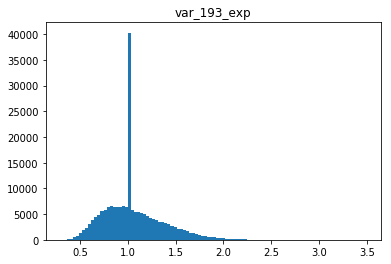

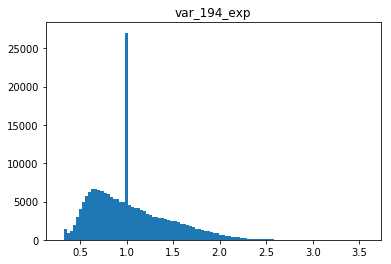

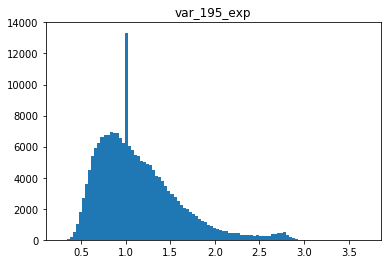

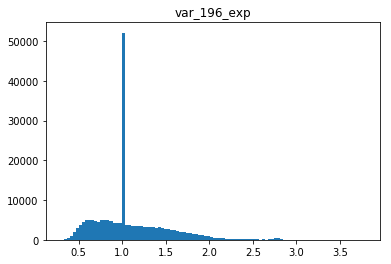

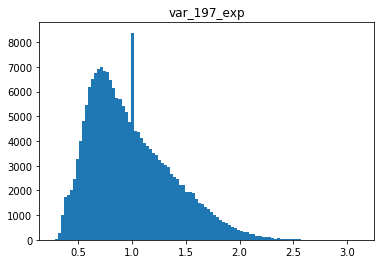

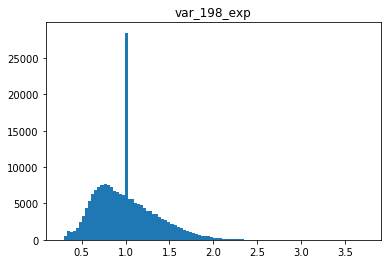

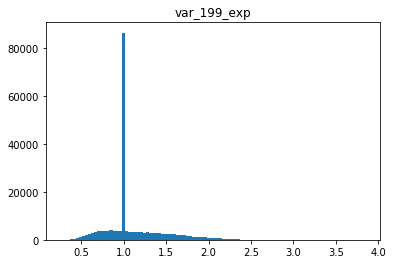

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for f in feature_cols:
    #plt.hist(train_df['var_4_freq']**train_df['var_4'], bins=100, range=(0, 100000)); plt.show()
    plt.title(f+'_exp')
    plt.hist(train_df[f+'_exp'], bins=100); plt.show()

In [6]:
import pandas as pd
import tensorflow as tf
from keras.preprocessing import text, sequence
import numpy as np
from keras.layers import Input, SpatialDropout1D,Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, \
                            CuDNNGRU, GRU, Bidirectional, CuDNNLSTM, Dense, Embedding, concatenate, Embedding, \
                            Flatten, Activation, BatchNormalization, regularizers, Conv1D, Conv2D, MaxPooling2D, Reshape, PReLU, \
                            GaussianNoise, Multiply, Add
from keras.constraints import max_norm
from keras.callbacks import *
from keras.initializers import Orthogonal
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LambdaCallback, Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
import keras.backend as K
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
import pickle
import gc; gc.enable()
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import string
from scipy.stats import boxcox
import re
from sklearn.model_selection import StratifiedKFold, KFold
#from tqdm import tqdm

# check gpu
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2470052585717788173
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10764343296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11268041809878859974
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
# build model
from keras.layers import *
from keras.models import Model

from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, activations
from keras.metrics import *

def build_model():
    # share components
    inputs = Input(shape=(200,2))
    
    main = inputs
    main = Dense(64, activation='relu')(main)
    main = Dense(32, activation='relu')(main)
    #main = BatchNormalization()(main)
    main = Flatten()(main)
    
    #main = concatenate([main, cnt_main])
    
    out = Dense(1, activation = 'sigmoid')(main) # 1 class to be classified

    model = Model(inputs, out)
    model.regularizers = [regularizers.l2(0.0001)]
    
    # use over weights
    model.compile(optimizer = Adam(lr=0.001, clipnorm=1.), loss="binary_crossentropy")
    
    #model.summary()
    return model

model = build_model()
model.summary()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 3)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 200, 64)           256       
_________________________________________________________________
dense_2 (Dense)              (None, 200, 32)           2080      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6401      
Total params: 8,737
Trainable params: 8,737
Non-trainable params: 0
_________________________________________________________________


In [8]:
# training
from datetime import datetime
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress
from sklearn.model_selection import KFold, StratifiedKFold
import warnings; warnings.filterwarnings('ignore') 
from sklearn.metrics import accuracy_score, roc_auc_score

class auc_score_monitor(Callback):
    def __init__(self, val_data, val_target, checkpoint_file, min_lr =1e-5, reduce_lr_patience=2, early_stop_patience=4, factor=0.1):
        self.val_data = val_data
        self.val_target = val_target
        self.checkpoint_file = checkpoint_file
        self.reduce_lr_patience = reduce_lr_patience
        self.early_stop_patience = early_stop_patience
        self.best_val_score = 0
        self.epoch_num = 0
        self.factor = factor
        self.unimproved_lr_counter = 0
        self.unimproved_stop_counter = 0
        self.min_lr = min_lr
        
    def on_train_begin(self, logs={}):
        self.val_scores = []
        
    def on_epoch_end(self, epoch, logs={}):
        val_pred = self.model.predict(self.val_data).reshape((-1,))
        val_score = roc_auc_score(self.val_target, val_pred)
        # clip pred
        self.val_scores.append(val_score)
        
        #print(self.val_target, '\n', val_pred)
        print('Epoch {} val_score: {:.5f}'.format(self.epoch_num, val_score))
        self.epoch_num += 1
        
        if val_score > self.best_val_score:
            print ('Val Score improve from {:5f} to {:5f}'.format(self.best_val_score, val_score))
            self.best_val_score = val_score
            self.unimproved_lr_counter = 0
            self.unimproved_stop_counter = 0
            if self.checkpoint_file is not None:
                print('Saving file to', self.checkpoint_file)
                self.model.save_weights(self.checkpoint_file)
        else:
            if val_score<self.best_val_score:
                print('no improve from {:.5f}'.format(self.best_val_score))
                self.unimproved_lr_counter += 1
                self.unimproved_stop_counter += 1
            
        if self.reduce_lr_patience is not None and self.unimproved_lr_counter >= self.reduce_lr_patience:
            current_lr = K.eval(self.model.optimizer.lr)
            if current_lr > self.min_lr:
                print('Reduce LR from {:.6f} to {:.6f}'.format(current_lr, current_lr*self.factor))
                K.set_value(self.model.optimizer.lr, current_lr*self.factor)
                #self.model.load_weights(self.checkpoint_file)
            else:
                pass
            
            self.unimproved_lr_counter = 0
            
        if self.early_stop_patience is not None and self.unimproved_stop_counter >= self.early_stop_patience:
            print('Early Stop Criteria Meet')
            self.model.stop_training = True
                
        return

In [9]:
import keras
import gc

def special_reshape(vals):
    return np.vstack([v.reshape((3,-1)).T.reshape((1, -1, 3)) for v in vals])

class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, positive_rate=1., negative_rate=1.,
                 pl_data=None, pl_soft_label=None, pl_sample_rate=1.):
        #'Initialization'
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.positive_rate = positive_rate
        self.negative_rate = negative_rate 
        self.pl_data = pl_data
        self.pl_soft_label = pl_soft_label
        self.pl_sample_rate = pl_sample_rate
        self.on_epoch_end()
        
    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.resampled_y) / self.batch_size))

    def __getitem__(self, index):
        #'Generate one batch of data'
        # Generate indexes of the batch
        start = index*self.batch_size
        end = min((index+1)*self.batch_size, len(self.resampled_y))
        indexes = np.arange(len(self.resampled_y))[start: end]

        # Generate data
        return self.resampled_X[indexes,:,:], self.resampled_y[indexes]

    def on_epoch_end(self):
        # resample + shuffle
        feat_len = self.X.shape[1]//3
        
        if self.pl_data is not None:
            pl_idx = np.random.choice(np.arange(self.pl_data.shape[0]), 
                                      size=int(self.pl_data.shape[0]*self.pl_sample_rate), 
                                      replace=False)
            
            pl_y = self.pl_soft_label[pl_idx].copy()
            pl_x = self.pl_data[pl_idx,:].copy()
            
            pl_y_rank = pd.Series(pl_y).rank(ascending=False)
            filt = pl_y_rank<=int(len(pl_y)*.1) # mark top 10 % rank data as 1
            pl_y[filt] = 1.
            pl_y[~filt] = 0.
            
            X_p = np.concatenate([self.X[self.y==1], pl_x[pl_y==1]], axis=0)
            X_n = np.concatenate([self.X[self.y==0], pl_x[pl_y==0]], axis=0)
        else:    
            X_p = self.X[self.y==1]
            X_n = self.X[self.y==0]
        
        pos_size = int(self.positive_rate*X_p.shape[0])
        X_p_new = np.zeros((pos_size, X_p.shape[1])).astype(np.float32)
        neg_size = int(self.negative_rate*X_n.shape[0])
        X_n_new = np.zeros((neg_size, X_n.shape[1])).astype(np.float32)
        
        for f in range(feat_len):
            pos_idx = np.random.choice(np.arange(X_p.shape[0]), size=pos_size, replace=True)
            X_p_new[:, f] = X_p[pos_idx,f]
            X_p_new[:, f+feat_len] = X_p[pos_idx,f+feat_len]
            X_p_new[:, f+2*feat_len] = X_p[pos_idx,f+2*feat_len]
            
            neg_idx = np.random.choice(np.arange(X_n.shape[0]), size=neg_size, replace=True)
            X_n_new[:, f] = X_n[neg_idx,f]
            X_n_new[:, f+feat_len] = X_n[neg_idx,f+feat_len]
            X_n_new[:, f+2*feat_len] = X_n[neg_idx,f+2*feat_len]
            
        self.resampled_X = np.vstack([X_p_new, X_n_new])
        self.resampled_y = np.array([1]*pos_size+[0]*neg_size)
        
        seq = np.random.choice(np.arange(len(self.resampled_y)), size=len(self.resampled_y), replace=False)
        self.resampled_X = special_reshape(self.resampled_X[seq, :])
        self.resampled_y = self.resampled_y[seq]
        #print(self.resampled_X.shape, self.resampled_y.shape)

In [10]:
seed = 0
train_epochs = 50
batch_size=32 # 32 or 64 is good (too huge for my PC), 128 is worse in the past experiments
cpu_count=4  
n_classses = 1
fold_num = 4
model_prefix = 'nn-aug-v5' #'rnn-with-marcus-features-v4'
bags = 10
pseudo_label = False
pseudo_label_sample_rate = 0.8

In [2]:
#from clr_callback import CyclicLR

for b in range(bags):
    fold = 0  
    retrain_fold = None

    for tr_ix, val_ix in KFold(fold_num, shuffle=True, random_state=seed).split(target, target):    
        fold += 1

        print("fold = {}, bag = {}".format(fold, b))
        
        if retrain_fold is not None and fold not in retrain_fold:
            continue

        #if fold < 3: continue

        tr = train_df.values[tr_ix,:]
        tr_y = target[tr_ix]
        
        if pseudo_label:
            pseudo_train = test_df.values[real_samples_indexes,]
            pseudo_y = pd.read_pickle("oof+submission/nn-aug-v3_fold_4_seed_0_oof_test")[real_samples_indexes]
        else:
            pseudo_train = None
            pseudo_y = None
        
        val = special_reshape(train_df.values[val_ix,:])
        val_y = target[val_ix]

        model = build_model()
        file_path = "model_weights/{}_fold_{}_bag_{}.hdf5".format(model_prefix, fold, b)

        '''
        early_stop = EarlyStopping(patience=4)
        lr_schd = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-5, verbose=1)
        check_point = ModelCheckpoint(file_path, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
        wmlog_loss_monitor = auc_score_monitor(val, target[val_ix], 
                                               checkpoint_file=None, reduce_lr_patience=None, early_stop_patience=None, 
                                               factor=None)
        '''
        lrs = [0.001]*7+[0.0001]*10+[0.00001]*5
        lr_schd = LearningRateScheduler(lambda ep: lrs[ep], verbose=1)
        wmlog_loss_monitor = auc_score_monitor(val, target[val_ix], 
                                               checkpoint_file=None, reduce_lr_patience=None, early_stop_patience=None, 
                                               factor=None) # calculate weighted m log loss per epoch

        training_generator = DataGenerator(tr, tr_y, batch_size=batch_size, positive_rate=2., negative_rate=1.,
                                           pl_data=pseudo_train, pl_soft_label=pseudo_y, pl_sample_rate=pseudo_label_sample_rate)
        history = model.fit_generator(generator=training_generator,
                                      validation_data=(val, val_y),
                                      use_multiprocessing=False,
                                      workers=1, 
                                      epochs=len(lrs),
                                      verbose = 0, 
                                      callbacks = [#early_stop, lr_schd, check_point,
                                                   lr_schd,
                                                   wmlog_loss_monitor, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
        model.save_weights(file_path)
        del training_generator; gc.collect()
        K.clear_session()
    
# input 200-2, dense 32-dense 16 (4 fold), n:9, p:1 : 1st fold: 0.91995, cv: , lb:
# input 200-2, dense 32-dense 16 (4 fold), n:9, p:2 : (logloss early stop), 0.91700
# input 200-2, dense 64-dense 32 (4 fold), n:9, p:2 (logloss early stop), 0.917186
# (v1) input 200-2, dense 64-dense 32 (4 fold), n:9, p:2 (auc early stop):, 0.92211
#          CV Mean = 0.92401, Std = 0.00124 all 0.9239874383173725, lb: 0.923
# input 200-2, dense 64-dense 32 (4 fold), n:9, p:9 (auc early stop): 0.92154, 
# input 200-2, dense 64-dense 32 (4 fold), n:9+9, p:1+1 (auc early stop): 0.9210, 
# input 200-2, dense 64-dense 32 (4 fold), n:9+9, p:1+2 (auc early stop): 0.9214, 
# input 200-2, dense 64-dense 32 (4 fold), n:9, p:3 (auc early stop): 0.92219
# input 200-2, dense 64-dense 32 (4 fold), n:9, p:4 (auc early stop): 0.9216
# (v2) input 200-2, dense 64-dense 32 (4 fold), n:9, p:2 (no early stop):, 0.92222
#          CV Mean = 0.92418, Std = 0.00153 all 0.9241816655071012, lb: 0.923
# input 200-2, dense 64-dense 64 (4 fold), n:9, p:2 (no early stop): 0.92224, 
# input 200-2, dense 128-dense 32 (4 fold), n:9, p:2 (no early stop): 0.92250, 
# input 200-2, dense 256-dense 32 (4 fold), n:9, p:2 (no early stop): 0.92173 
# input 200-2, dense 128-dense 64 (4 fold), n:9, p:2 (no early stop): 0.92180,
# input 200-2, dense 64-dense 16 (4 fold), n:9, p:2 (no early stop): 0.92175,
# input 200-2, dense 64-dense 32-flat-bn-dp03-dense 16- (4 fold), n:9, p:2 (no early stop): 0.92119, 
# input 200-2, dense 16x4-concat-dense 32 (4 fold), n:9, p:2 (no early stop): 0.92182, 
# input 200-2, dense 64-dense 32, data no normalize (4 fold), n:9, p:2 (no early stop): 0.90745 
# (v3) v2 + 10 bags average: 
#          CV Mean = 0.9241x, overall=.9249 lb: 0.924

# input 200-2, dense 128-dense 32 (4 fold), n:9, p:4 (no early stop): 0.92230, 
# input 200-2, dense 64-dense 32-dense 16 (4 fold), n:9, p:4 (no early stop): 0.92202, 
# input 200-2, dense 64-dense 32 (4 fold), n:9, p:2 (no early stop), pl samples: 100%, 0.92348
# input 200-2, dense 64-dense 32 (4 fold), n:9, p:2 (no early stop), pl samples: 80%, 0.9241
# input 200-2, dense 64-dense 32 (4 fold), n:9, p:2 (no early stop), pl samples: 60%, 0.92324
# input 200-2, dense 64-dense 32 (4 fold), n:9, p:2 (no early stop), pl samples: 90%, 0.92313
# (v4) v2 + 10 bags average + pl samples: 80%: 0.92369
#          CV Mean = 0.92588, Std = 0.00163 all 0.926449481043902. lb: 0.924
# v2 + all features normalized separately: 0.91985
# v2 + count features normalized together: 0.91995
# v2 + add count features interactions: 0.92166
# v2 + add expected sample count: 0.92068
# v2 + gaussian noise 0.01: 0.92207
# v2 + gaussian noise 0.1: 0.92217
# v2 + multiply:

NameError: name 'feature_cols' is not defined

In [ ]:
train_oof = np.zeros((train.shape[0],))
test_oof = np.zeros((test.shape[0],))

train_aucs = []

model = build_model()
    
for b in range(bags):
    fold=0
    for tr_ix, val_ix in KFold(fold_num, shuffle=True, random_state=seed).split(target, target):    
        fold += 1
        val = special_reshape(train_df.values[val_ix,:])
        val_y = target[val_ix]

        file_path = "model_weights/{}_fold_{}_bag_{}.hdf5".format(model_prefix, fold, b)

        # Predict val + test oofs
        model.load_weights(file_path) # load weight with best validation score

        pred = model.predict(val, batch_size=batch_size).reshape((len(val_ix),))
        train_oof[val_ix] += pred
        val_auc = roc_auc_score(target[val_ix], pred)
        train_aucs.append(val_auc)
        print('val acc = {:.5f}'.format(val_auc))

        test_oof += model.predict(special_reshape(test_df.values), batch_size=batch_size).reshape((test.shape[0],))/fold_num

train_oof /= bags
test_oof /= bags
K.clear_session()

In [ ]:
# V2 Reference: 0.92252, 0.92306, 0.92547, 0.92498
train_aucs = np.array(train_aucs)
for fold in range(fold_numnum):
    print(train_aucs[fold::fold_num].mean())

In [ ]:
train_aucs

In [ ]:
full_auc = roc_auc_score(target, train_oof)
print('CV Mean = {:.5f}, Std = {:.5f}'.format(np.mean(train_aucs), np.std(train_aucs)), 'all', full_auc)

In [ ]:
pd.to_pickle(train_oof, "oof+submission/{}_fold_{}_seed_{}_oof_train".format(model_prefix, fold_num, seed))
pd.to_pickle(test_oof, "oof+submission/{}_fold_{}_seed_{}_oof_test".format(model_prefix, fold_num, seed))
sub = pd.DataFrame({"ID_code": test.ID_code.values})
sub["target"] = test_oof
sub.to_csv('oof+submission/' + model_prefix + '_' + str(full_auc).replace('.', '_') + ".csv", index=False)